# What is Time Series

Time series is a **sequence** of data in successive order of time. The value of data when combined with time ofen become more useful. We can gain more information by doing timeseries analysis, wich often resulting in forecasting. Let's take a look in a most common time series data, stock data.

In [18]:
from pandas_datareader import data
import pandas as pd

In [19]:
symbol = ['AAPL', 'BBCA.JK']
source = 'yahoo'
start_date = '2012-01-01'
end_date = '2020-01-20'
stock = data.DataReader(symbol, source, start_date, end_date)
# stock = pd.read_pickle('stock')


In [20]:
apple = stock.xs('AAPL', level='Symbols', axis=1)
apple

Attributes   Adj Close       Close        High         Low        Open  \
Date                                                                     
2012-01-02         NaN         NaN         NaN         NaN         NaN   
2012-01-03   51.115936   58.747143   58.928570   58.428570   58.485714   
2012-01-04   51.390648   59.062859   59.240002   58.468571   58.571430   
2012-01-05   51.961189   59.718571   59.792858   58.952858   59.278572   
2012-01-06   52.504375   60.342857   60.392857   59.888573   59.967144   
...                ...         ...         ...         ...         ...   
2020-01-14  312.679993  312.679993  317.570007  312.170013  316.700012   
2020-01-15  311.339996  311.339996  315.500000  309.549988  311.850006   
2020-01-16  315.239990  315.239990  315.700012  312.089996  313.589996   
2020-01-17  318.730011  318.730011  318.739990  315.000000  316.269989   
2020-01-20         NaN         NaN         NaN         NaN         NaN   

Attributes      Volume  
Date                    
2012-01-02         NaN  
2012-01-03  75555200.0  
2012-01-04  65005500.0  
2012-01-05  67817400.0  
2012-01-06  79573200.0  
...                ...  
2020-01-14  40488600.0  
2020-01-15  30480900.0  
2020-01-16  27207300.0  
2020-01-17  34454100.0  
2020-01-20         NaN  

[2083 rows x 6 columns]

In [21]:
apple = apple.resample('D').mean().fillna(method='ffill').fillna(method='bfill')

In [22]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
# import matplotlib
# matplotlib.rcParams['axes.labelsize'] = 14
# matplotlib.rcParams['xtick.labelsize'] = 12
# matplotlib.rcParams['ytick.labelsize'] = 12
# matplotlib.rcParams['text.color'] = 'k'

In [23]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

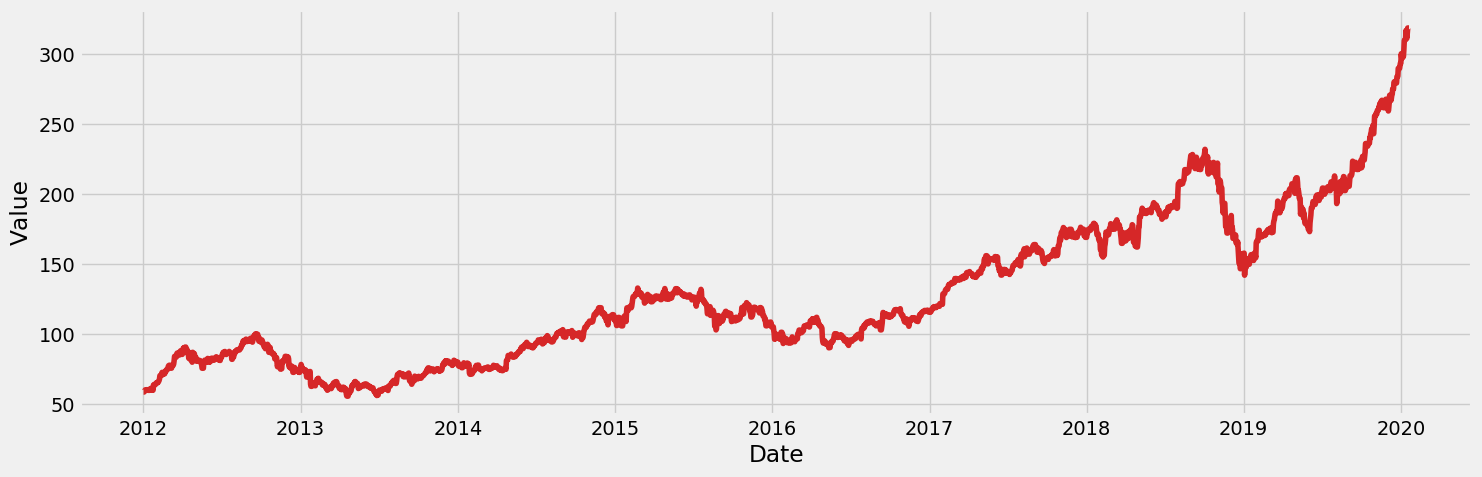

In [24]:
plot_df(apple, apple.index, apple['Close'])

# Time series Components

There are three components of time-series data: 
- Trend: the movement of the data on a larger scale (moving average)
- Seasonality: repeated seasonal fluctuations
- Residual: any fluctuations not captured from trend or seasonality (should be random)

A time series can be modeled as **additive** or **multiplicative** time series depending on its nature of trend and seasonality. \
**Aditive Time Series** \
observed = Trend + Seasonal + Residual \
**Multiplicative Time Series** \
observed = Trend $\times$ Seasonal $\times$ Residual

*Source: Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on January 22, 2020.*

So, how we diffrentiate additive and multiplicative time series, please take a look an example image below ([source](https://kourentzes.com/forecasting/2014/11/09/additive-and-multiplicative-seasonality/))
![](res/add_vs_multi.png)

Based on data values, if the magnitude of seasonality changes overtime (see image on the right), then the data is multiplicative. Our data however doesn't show clear evidence of growing/shrinking magnitude of seasonality, so we assume it's an additive time series. Now let's try to extract the sub0components. 

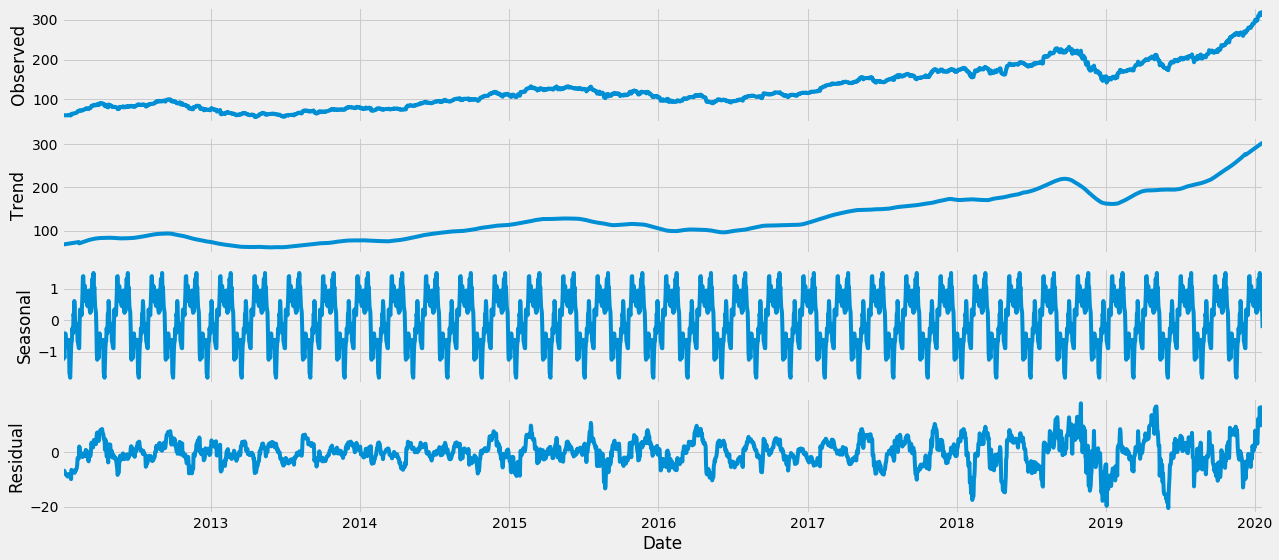

In [25]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(apple['Close'], model='additive', freq=7*4*3,extrapolate_trend='freq')
fig = decomposition.plot()
plt.show()

On the example above, we are using `freq= 7*4*3` (~3 months) to model our data. You can tune it by holding into `trend` visualizations. If the trends visualizations is smooth, and the seasonal has patterns, then it's good to continue. 

The `extrapolate_trend='freq'` will make the length of residual, trend, and seasonal the same by taking care of any missing values at the beginning of the series. 

Now that we already decompose the data, let's try to reconstruct and see whether the formula are correct or not. 

In [26]:
apple_rc = pd.concat([decomposition.seasonal, decomposition.resid, decomposition.trend, decomposition.observed], axis=1)
apple_rc.columns = ['seasonal', 'residual', 'trend', 'observation']
apple_rc['total'] = apple_rc['seasonal'] + apple_rc['residual'] + apple_rc['trend']
apple_rc

seasonal   residual       trend  observation       total
Date                                                                
2012-01-02 -0.255056  -8.553381   67.555580    58.747143   58.747143
2012-01-03 -1.045363  -7.913242   67.705748    58.747143   58.747143
2012-01-04 -1.261384  -7.531672   67.855915    59.062859   59.062859
2012-01-05 -0.976904  -7.310608   68.006082    59.718571   59.718571
2012-01-06 -1.051264  -6.762128   68.156250    60.342857   60.342857
...              ...        ...         ...          ...         ...
2020-01-16  0.727528  13.379360  301.133102   315.239990  315.239990
2020-01-17  0.423105  16.490818  301.816088   318.730011  318.730011
2020-01-18  0.335488  15.895449  302.499074   318.730011  318.730011
2020-01-19  0.247872  15.300079  303.182060   318.730011  318.730011
2020-01-20 -0.255056  15.120022  303.865046   318.730011  318.730011

[2941 rows x 5 columns]

In [27]:
(apple_rc['total'] == apple_rc['observation']).mean()

1.0

From code above, we have a proof that the formula is true. 

# Stationary

Stationary time-series is time series data that the values don't follow a function of time. 

The difference between stationary time-series and non stationary can be obvious in these example ([source](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322))
![](res/stationary.png)



By the example above, we can conclude that variance in stationary time-series will likely to be constant for each window. Why we need stationary time-series? it's because stationary time-series is easier to be analyzed and most of forecasting algorithm works well with stationary time-series.

## Change into stationary time-series

There are some ways to make a series into stationary: 
- Differencing the Series
- Transform the series to its log 
- Transform the series to its root 
- Other combination

since our data is additive, let's try to difference it using `.diff` method.

In [67]:
apple_st = apple.diff(1)
apple_st.head()

Attributes           Adj Close              Close               High  \
Date                                                                   
2012-01-02                 nan                nan                nan   
2012-01-03                 0.0                0.0                0.0   
2012-01-04 0.27471160888671875 0.3157157897949219  0.311431884765625   
2012-01-05  0.5705413818359375 0.6557121276855469    0.5528564453125   
2012-01-06  0.5431861877441406 0.6242866516113281 0.5999984741210938   

Attributes                 Low                Open        Volume  
Date                                                              
2012-01-02                 nan                 nan           nan  
2012-01-03                 0.0                 0.0           0.0  
2012-01-04 0.04000091552734375 0.08571624755859375 -10,549,700.0  
2012-01-05  0.4842872619628906  0.7071418762207031   2,811,900.0  
2012-01-06  0.9357147216796875  0.6885719299316406  11,755,800.0

If we see, the first data values will be missing since there are no data beforehead. Let's assume that it's the first data, so the difference between the previous one is zero using fillna(0))

In [68]:
apple_st = apple_st.fillna(0)
apple_st.head()

Attributes           Adj Close              Close               High  \
Date                                                                   
2012-01-02                 0.0                0.0                0.0   
2012-01-03                 0.0                0.0                0.0   
2012-01-04 0.27471160888671875 0.3157157897949219  0.311431884765625   
2012-01-05  0.5705413818359375 0.6557121276855469    0.5528564453125   
2012-01-06  0.5431861877441406 0.6242866516113281 0.5999984741210938   

Attributes                 Low                Open        Volume  
Date                                                              
2012-01-02                 0.0                 0.0           0.0  
2012-01-03                 0.0                 0.0           0.0  
2012-01-04 0.04000091552734375 0.08571624755859375 -10,549,700.0  
2012-01-05  0.4842872619628906  0.7071418762207031   2,811,900.0  
2012-01-06  0.9357147216796875  0.6885719299316406  11,755,800.0

In [69]:
plot_df(apple_st, apple_st.index, apple_st['Close'])

Based on the chart, our transformed data seems more stationary. If you're a bit skeptical about the result, there exists several measurement to test data stationarity: 
- Augmented Dicky Fuller (ADF) test
- Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)

Let's try using ADF, the most common way to test stationarity. 

In [70]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(apple_st['Close'])
print(f"""
ADF Value : {adf_test[0]}
P Value : {adf_test[1]}
""")



ADF Value : -7.930792441536947
P Value : 3.517685147152115e-12



When you run the ADF test, the result should be negative value, and the P-value should beneath certain threshold. For example, we will use p-value < 5%. Based on the result, the ADF Value is -7 wich means our data is stationary enough. with confidental value (p-value) < 5%, it means that our data is statistically stationary. 

But, doing transformation means we changed the data. Yes, **we changed the data**. But don't worry, we can still try to reconstruct it into original form. However, it depends on how you changed the data. Since we are using diff wich resuling in the differences between current data and previous one, a cumulative sum (`cumsum`) will work as a cure. 

In [71]:
plot_df(apple_st, apple_st.index, apple_st.cumsum()['Close'])

However, doing a cumulative sum doesn't re-transfrom the data into its original value. This is caused by the first value of the data is zero (previously nan, changed to zero). We need the initial data so that it can transform into it's original values. 

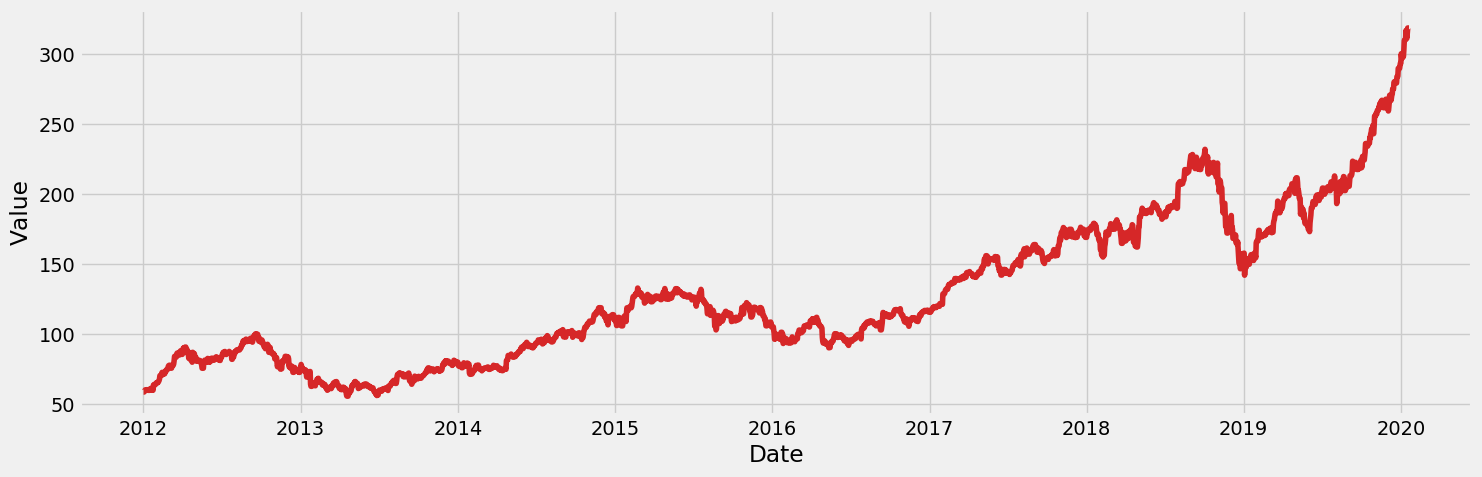

In [74]:
# return the first value of the data to be original value 
apple_st.iloc[0,:] = apple.iloc[0,:]
plot_df(apple_st, apple_st.index, apple_st.cumsum()['Close'])

# Time Series Forecasting

## Modelling

## Model Evaluation